## Configuration

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import re
from collections import defaultdict  # For word frequency
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm
import IPython #for HTML viz

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from peertax.LDA_Diagnostic import LDA_Conv, LDA_Scores

## Model selection

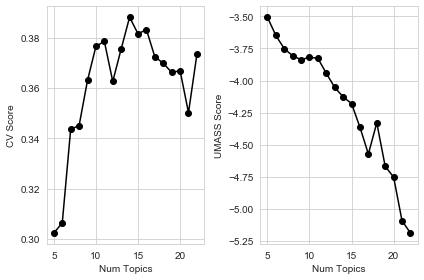

In [2]:
base_pth = './f1000_LDA_Sentence_Run_3/'
cv_arr, um_arr = LDA_Scores(base_pth)

plt.subplot(1,2,1)
plt.plot(cv_arr[:,0],cv_arr[:,1],'ko-')
plt.ylabel("CV Score")
plt.xlabel("Num Topics")

plt.subplot(1,2,2)
plt.plot(um_arr[:,0],um_arr[:,1],'ko-')
plt.ylabel("UMASS Score")
plt.xlabel("Num Topics")
plt.tight_layout()

Best model (highest CV Score) is Model_14.

Load corpus from Run_2 and Model_14

In [3]:
num_topics = '14'
model_no = 'Model_' + num_topics
model_pth = base_pth + model_no

# Load sentence data from tsv
path_load_tsv = '../pickles/f1000_tokenized_LDA_sentence_3.tsv'
df = pd.read_csv(path_load_tsv,sep='\t',quoting=csv.QUOTE_NONE)
df.drop(columns=['Unnamed: 0'],inplace=True)
df['token'] = df['token'].str.split(',')
#path_load_tsv = '../pickles/f1000_tokenized_LDA_sentence_3.pkl'
#df = pd.read_pickle(path_load_tsv)

# Create Corpus
texts = df['token']
#Load Model
lda_model = gensim.models.ldamodel.LdaModel.load(model_pth)
id2word = gensim.corpora.Dictionary.load(model_pth + '.id2word')
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print('Total number of sentences: %s' % len(corpus))

INFO - 17:28:42: loading LdaModel object from ./f1000_LDA_Sentence_Run_3/Model_14
INFO - 17:28:42: loading expElogbeta from ./f1000_LDA_Sentence_Run_3/Model_14.expElogbeta.npy with mmap=None
INFO - 17:28:42: setting ignored attribute state to None
INFO - 17:28:42: setting ignored attribute dispatcher to None
INFO - 17:28:42: setting ignored attribute id2word to None
INFO - 17:28:42: loaded ./f1000_LDA_Sentence_Run_3/Model_14
INFO - 17:28:42: loading LdaState object from ./f1000_LDA_Sentence_Run_3/Model_14.state
INFO - 17:28:42: loaded ./f1000_LDA_Sentence_Run_3/Model_14.state
INFO - 17:28:42: loading Dictionary object from ./f1000_LDA_Sentence_Run_3/Model_14.id2word
INFO - 17:28:42: loaded ./f1000_LDA_Sentence_Run_3/Model_14.id2word


Total number of sentences: 50811


Show topic visualization.

In [4]:
IPython.display.HTML(filename=model_pth+'.html')

In [5]:
lda_model.show_topics(num_topics=25, num_words=10, log=False, formatted=True)

[(0,
  '0.122*"paper" + 0.041*"good" + 0.037*"write" + 0.029*"discussion" + 0.023*"interesting" + 0.017*"author" + 0.014*"describe" + 0.012*"publish" + 0.011*"think" + 0.011*"limitation"'),
 (1,
  '0.037*"different" + 0.016*"difference" + 0.013*"model" + 0.013*"mean" + 0.012*"variable" + 0.012*"population" + 0.011*"author" + 0.010*"effect" + 0.010*"time" + 0.010*"participant"'),
 (2,
  '0.036*"current" + 0.023*"publication" + 0.023*"work" + 0.015*"datum" + 0.013*"new" + 0.012*"article" + 0.011*"review" + 0.011*"clear" + 0.009*"main" + 0.009*"need"'),
 (3,
  '0.087*"author" + 0.038*"point" + 0.032*"manuscript" + 0.030*"present" + 0.021*"discuss" + 0.016*"article" + 0.015*"clarify" + 0.014*"review" + 0.013*"important" + 0.013*"overall"'),
 (4,
  '0.071*"datum" + 0.044*"provide" + 0.030*"information" + 0.013*"analysis" + 0.012*"describe" + 0.012*"tool" + 0.011*"useful" + 0.010*"detail" + 0.010*"app" + 0.010*"web"'),
 (5,
  '0.101*"study" + 0.056*"result" + 0.047*"method" + 0.039*"analysis

Utility function to assign topics and percentages.

In [6]:
def topic_analysis(ldamodel=lda_model, corpus=corpus, texts=texts, index=df.index.values):
    # Init dictionary
    sent_topics_dict = {}
    # Get main topic in each document
    for i in tqdm(range(len(corpus))):
        row = corpus[i]
        top_scor = max(ldamodel.get_document_topics(row),key=itemgetter(1))
        topic_num = top_scor[0];
        prop_topic = top_scor[1];
        # Dictionary entry per row
        sent_topics_dict[i] = {'Dominant_Topic': int(topic_num),
                           'Perc_Contribution': round(prop_topic,4)}        
    # Create database from dictionary
    sent_topics_df = pd.DataFrame.from_dict(sent_topics_dict, "index")
    # Add original text to the end of the output
    sent_topics_df['texts'] = pd.Series(texts)
    sent_topics_df.set_index(index,inplace=True)
    
    return sent_topics_df

In [7]:
df_topic_analysis = topic_analysis(lda_model, corpus, df.sentences.values, df.index.values)

Group top reviews under each topic.

In [8]:
top_reviews_topic = pd.DataFrame()

df_topic_analysis_grpd = df_topic_analysis.groupby('Dominant_Topic')
for i, grp in df_topic_analysis_grpd:
    top_reviews_topic = pd.concat([top_reviews_topic, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(40)], 
                                            axis=0)

Investigate top sentences per topic.

In [9]:
num_top = 0
topic2_top_list = top_reviews_topic[top_reviews_topic['Dominant_Topic']==num_top].index.tolist()
for i in topic2_top_list:
    print(top_reviews_topic.loc[i,'texts'])
    #print(top_reviews_topic.loc[i])
    print('\n')

A minor detail is that although the language is excellent for a paper from a non-English speaking country, there are still a lot of grammatical errors that would benefit from editing by a native speaker.


4emissions on the water (soil) surface of paddy fields with and without rice .These are just a couple of examples. Perhaps the authors could contact a native speaker to have a quick look at their paper?


The article would then work its way down the food chain of journals before appearing in an obscure journal where few people would read it, especially if it appeared in a journal behind a paywall.


This paper could be useful to the horticulturists, especially those working on micropropagation; though, the findings of this paper, in my opinion, are common knowledge in the field of tissue culture.


Despite all these observations, I believe this paper deserves publication in order to start a serious discussion about scientific conferences.


The article language, style and clarity wou